<a href="https://colab.research.google.com/github/timeseriesAI/tsai/blob/master/tutorial_nbs/04_Intro_to_Time_Series_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import os
# 设置proxy
os.environ['http_proxy'] = 'http://127.0.0.1:7890'
os.environ['https_proxy'] = 'http://127.0.0.1:7890'

## Purpose 😇

> fastai 和 tsai 创建简单、端到端、最先进的时间序列回归模型。

simple, end-to-end, state-of-the-art **time series regression** model using **`fastai`** and **`tsai`**.

> 回归是一项将连续值分配给单变量或多变量时间序列的任务。

A time series regression is a task in which you assign a continuous value to a univariate or multivariate time series. 



## Import libraries 📚

In [1]:
from tsai.all import *
my_setup()

os              : Linux-5.15.0-97-generic-x86_64-with-glibc2.17
python          : 3.8.18
tsai            : 0.3.9
fastai          : 2.7.14
fastcore        : 1.5.29
torch           : 2.2.1+cu121
device          : 1 gpu (['NVIDIA GeForce GTX 1060 6GB'])
cpu cores       : 6
threads per cpu : 2
RAM             : 31.22 GB
GPU memory      : [6.0] GB


## Prepare data 🔢

> Monash、UEA 和 UCR 时间序列 Extrinsic 外在回归存储库 (2020)（网络、论文）中选择一个数据集。

We are going to select a dataset from the recently released Monash, UEA & UCR 
Time Series Extrinsic Regression Repository (2020) ([web](http://tseregression.org), [paper](https://arxiv.org/abs/2006.10996)). 


In [5]:
dsid = 'AppliancesEnergy'
X, y, splits = get_regression_data(dsid, split_data=False)
X.shape, y.shape, y[:10]

119it [00:01, 60.58it/s]
66it [00:00, 68.69it/s] 


((137, 24, 144),
 (137,),
 memmap([19.38, 12.68,  5.34, 12.72, 13.25, 26.28, 13.1 , 14.06, 10.92,
         10.46]))

三个元素的元组：

1. 一个元组表示一个3D数组的形状：`(137, 24, 144)`。数据集，其中包含137个样本，每个样本包含24个特征，跨越144个时间步骤。
2. 一个元组表示一个1D数组的形状：`(137,)`。这表明你有一个目标变量`y`，包含137个样本。
3. 一个`memmap`对象，这是一种通过将数组存储在磁盘上并以如同它们在内存中一样的方式访问它们来处理不适合内存的大型数组的方式。`memmap`对象包含10个值，这可能是每个137个样本的目标变量`y`。

处理一个时间序列回归问题，有137个样本，每个样本包含24个特征，跨越144个时间步骤，并且你正在尝试预测每个样本的目标变量`y`。`memmap`对象可能表示每个样本的目标变量`y`，以一种内存高效的方式存储。

使用这些数据与`tsai`库中的`check_data`函数，你需要确保`X`是你的3D特征数组，`y`是你的1D目标变量数组，并且`splits`是定义如何将你的数据分割成训练集和验证集的方式。`check_data`函数将打印出你的数据的形状、类型和任何NaN值的信息，如果`show_plot`设置为`True`，它还将绘制分割。

For regression tasks, we need to ensure y is a float. Let's check the format of the data:

> 对于回归任务，我们需要确保 y 是浮点数。我们来检查一下数据的格式：

X      - shape: [137 samples x 24 features x 144 timesteps]  type: memmap  dtype:float64  isnan: 0
y      - shape: (137,)  type: memmap  dtype:float64  isnan: 0
splits - n_splits: 2 shape: [95, 42]  overlap: False


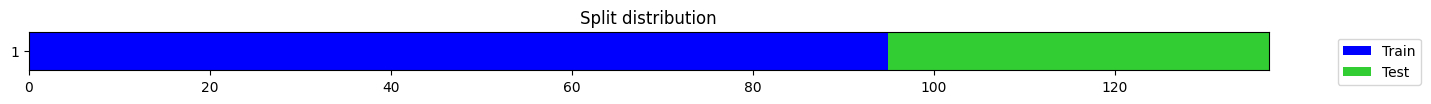

In [6]:
check_data(X, y, splits)

`check_data`函数的输出显示数据集的详细信息：

1. **X的信息**：
   - 形状：`[137 samples x 24 features x 144 timesteps]`，表示你有137个样本，每个样本包含24个特征，跨越144个时间步骤。
   - 类型：`memmap`，表示这是一个内存映射数组，这是一种高效处理大型数据集的方法，它允许你在不将整个数据集加载到内存中的情况下访问数据。
   - 数据类型（dtype）：`float64`，表示数据是64位浮点数。
   - 不包含NaN值（isnan: 0），这意味着你的数据集中没有缺失值。

2. **y的信息**：
   - 形状：`(137,)`，表示你有137个目标变量值。
   - 类型：`memmap`，与X相同，这是一个内存映射数组。
   - 数据类型（dtype）：`float64`，与X相同，这是64位浮点数。
   - 不包含NaN值（isnan: 0），这意味着你的目标变量中没有缺失值。

3. **splits的信息**：
   - 分割数量：2，表示你的数据被分割成了两个部分。
   - 形状：`[95, 42]`，表示第一个部分包含95个样本，第二个部分包含42个样本。
   - 没有重叠（overlap: False），表示这两个部分是独立的，没有重叠的样本。

数据集已经准备好用于时间序列回归任务，并且已经被分割成了训练集和验证集。可以继续使用这些数据进行模型训练和评估。如果你需要进一步的帮助，比如如何使用这些数据进行模型训练或评估

In [7]:
tfms  = [None, [TSRegression()]]
batch_tfms = TSStandardize(by_sample=True, by_var=True)
dls = get_ts_dls(X, y, splits=splits, tfms=tfms, batch_tfms=batch_tfms, bs=128)
dls.one_batch()

(TSTensor(samples:95, vars:24, len:144, device=cuda:0, dtype=torch.float32),
 tensor([14.7100, 17.0000, 10.8900, 18.1800, 21.9100, 12.7800, 16.2200, 16.0500,
         10.6200, 10.9200, 19.3800, 13.3700, 10.2500, 15.6800, 26.2800, 11.0600,
         14.0600, 19.6200, 19.0100, 12.6800, 12.7200, 14.2800, 10.8200,  5.3800,
         11.4900, 12.6800, 11.8300, 16.7700, 10.1700, 23.4200, 17.5300, 14.6200,
         12.9800, 14.8000, 12.2400, 14.9900, 20.7400, 10.6300, 10.1100, 12.5400,
         10.5100, 16.0200, 17.6600,  7.0300, 19.9400, 17.3000, 12.9700, 23.0100,
         10.6100, 12.0300, 13.5600, 21.3100, 13.2100, 11.5400, 10.5100, 10.3100,
         11.6300, 13.6900, 11.9300, 21.6900,  9.6300, 16.2500, 12.0700, 11.5300,
         11.3200, 22.7400, 13.2900, 14.8200,  9.8200, 10.8000, 14.6100, 10.2600,
         18.5600,  8.6200, 13.2500, 22.1000, 16.5300, 21.4900,  9.1700, 11.6400,
          8.7500, 10.4600, 15.8900, 20.4400, 11.2300, 13.8700, 13.1000, 19.2200,
         11.4000,  9.6000,  9.99

提供的信息包含了两个主要部分：

1. **TSTensor对象**：
   - 样本数：95个
   - 变量数：24个
   - 长度：144
   - 设备：`cuda:0`，表示这个Tensor在GPU上
   - 数据类型：`torch.float32`，表示数据是32位浮点数

2. **PyTorch张量（Tensor）**：
   - 形状：`(1, 42)`，表示这是一个一维张量，包含42个元素。
   - 设备：`cuda:0`，与TSTensor对象相同，表示这个张量也在GPU上。

这些信息表明你正在使用PyTorch进行深度学习模型的训练或推理，并且你的数据已经被转换成了适合GPU加速的格式。TSTensor对象是一个特殊的数据结构，用于处理时间序列数据，它包含了样本数、变量数、长度等信息，这对于时间序列分析非常有用。而PyTorch张量则是用于存储和操作数据的基本数据结构，它可以在CPU或GPU上运行。

比如如何使用这些数据进行模型训练或评估，或者如何在PyTorch中处理时间序列数据，请告诉我！


TSDatasets 将其识别为回归问题，因为第二个输出（ys）是浮点数。这就是为什么类的数量设置为 1。这是为了能够正确使用 timesereisAI 中可用的时间序列模型。

> `TSDatasets` identifies this as a regression problem, as the 2nd output (the ys) are floats. That's why the number of classes is set to 1. This is required to be able to correctly use the time series models available in `timesereisAI`.

In [8]:
dls.c

1

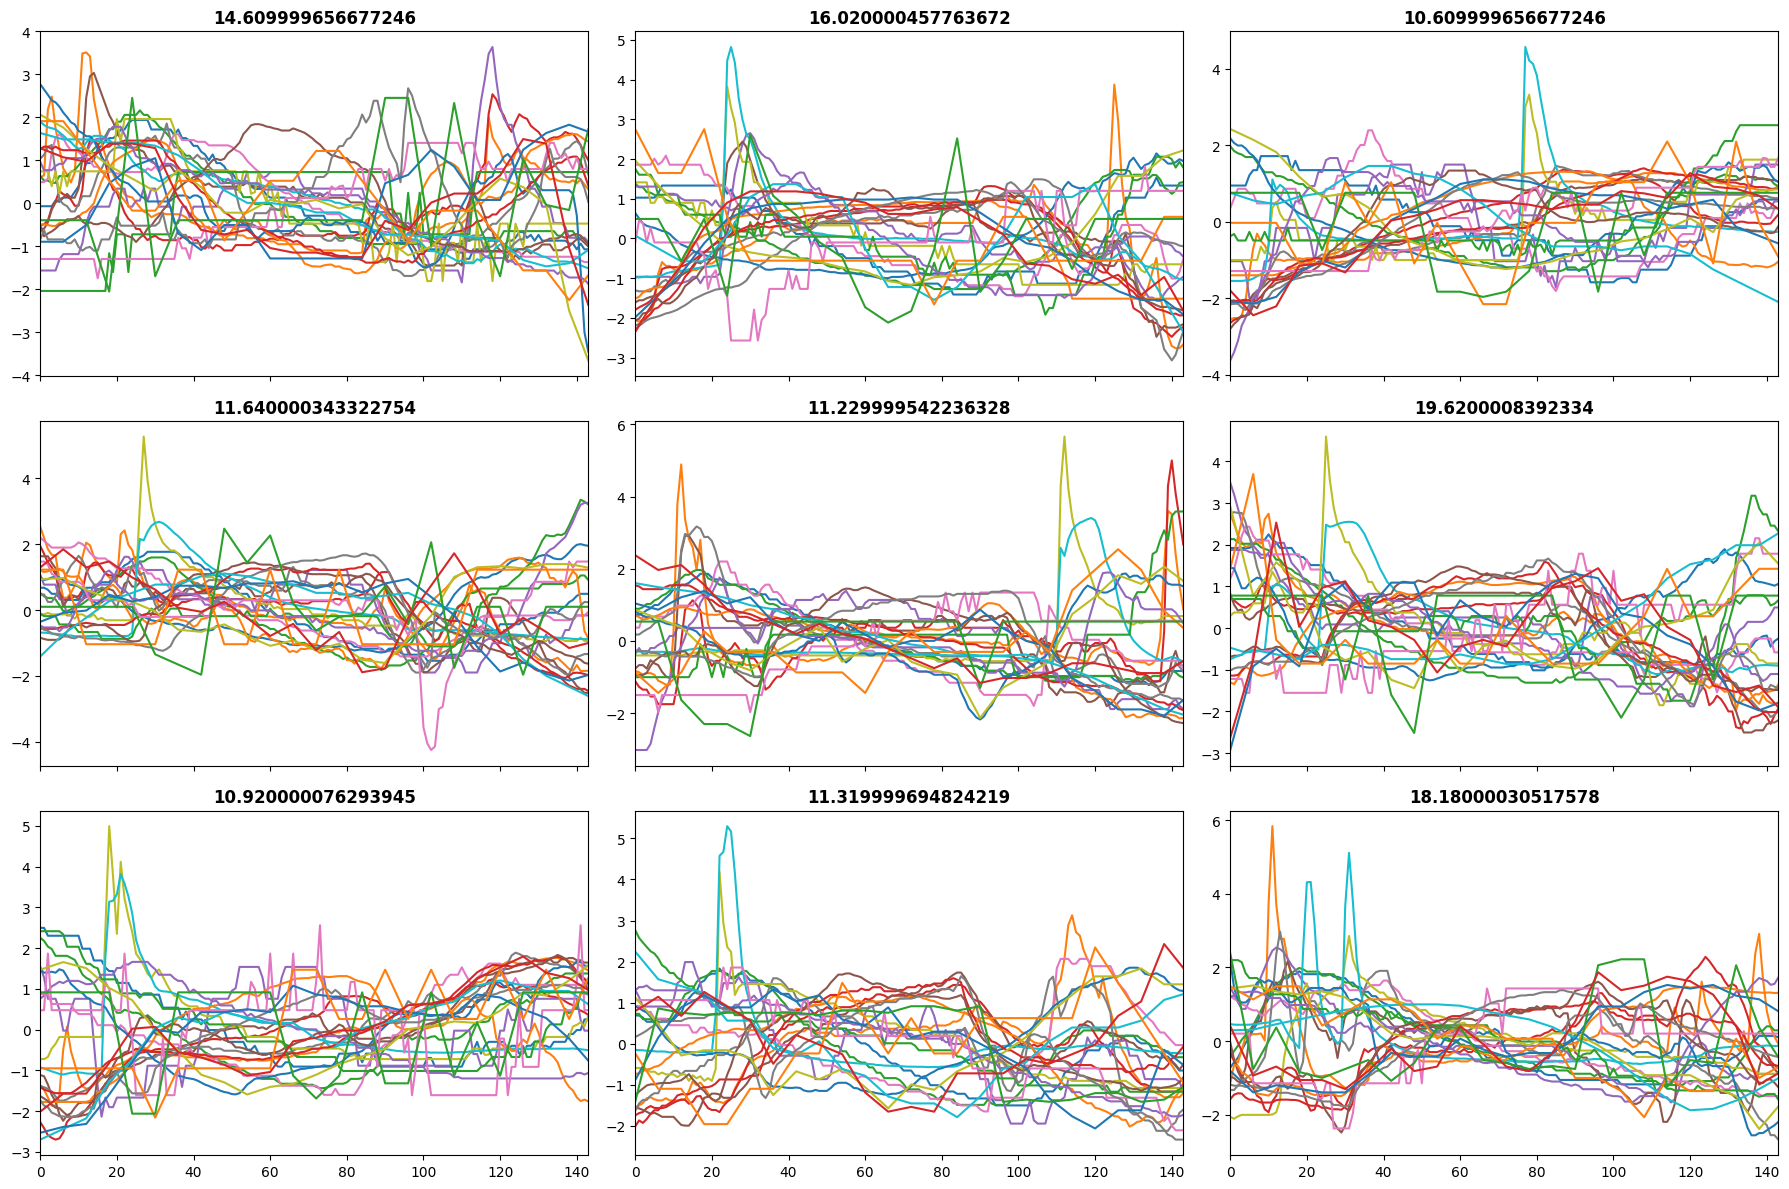

In [9]:
dls.show_batch()

## 创建学习器

> Build learner 🏗

* 模型：我们可以选择 timeseriesAI 中可用的任何时间序列模型。适用于分类的同样适用于回归。在本例中，我们将使用名为 InceptionTime 的最先进的时间序列模型。
* > Model: we can choose any of the time series models available in `timeseriesAI`. The same ones that work for classification also work for regression. In this case we'll use a state-of-the-art time series model called ` InceptionTime`.
* 损失：由于这是一个回归问题，我们将使用回归损失（ MSELossFlat ）。但是，不需要将其传递给学习者，因为它会自动推断所需的损失。
* > Loss: since this is a regression problem, we''l use a regression loss (`MSELossFlat`). However, there's not need to pass it to the Learner, as it will automatically infer the required loss.
* 指标：我们还将选择回归指标。 （ mse 将返回与我们选择的损失相同的结果。只是为了演示目的而添加它）
* > Metrics: we'll also choose regression metrics. (`mse` will return the same result as the loss we have selected. Just added it for demo purposes).

SuggestedLRs(valley=0.0012022644514217973)

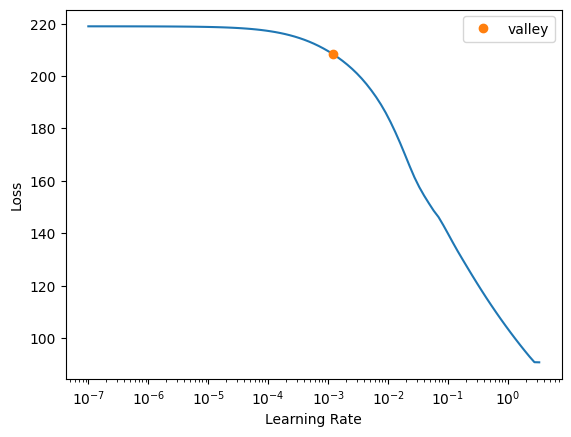

In [10]:
learn = ts_learner(dls, InceptionTime, metrics=[mae, rmse], cbs=ShowGraph())
learn.lr_find()

您上传的图像通常是由机器学习库（例如 fastai ）中的 lr_find 方法生成的绘图。该方法用于找到训练模型的良好学习率。该图显示纵轴上的损失作为横轴上学习率的函数，横轴上以对数刻度绘制

以下是我们可以从图中推断出的内容的分析：
1. 该图从非常低的学习率 (10^-7) 开始，然后增加到更大的值（10^0 或 1）
2. 着学习率从最低值开始增加，损失急剧减小，表明模型正在学习和改进
3. 有一个点用橙色点标记为“山谷”，它对应于训练模型的建议学习率。这是损失相对较低且开始快速增加之前的点，这表明学习率过高。
4. 代码片段中提供的建议学习率为 0.0012022644514217973，这可能是绘图上橙色点的 x 坐标。

这种图在深度学习领域非常有用，可以选择既不能太高（这会导致由于更新不稳定而导致损失增加）也不能太低（这会使训练过程不必要地变慢）的学习率。
学习率是训练模型时要设置的最重要的超参数之一，使用学习率查找器有助于更科学地设置此超参数，而不仅仅是猜测。

代码中的 ts_learner 函数建议你正在使用 InceptionTime 体系结构与时间序列学习器合作，并且你正在监视平均绝对误差 （mae） 和均方根误差 （rmse） 作为指标。ShowGraph 回调可能用于在调用 lr_find 方法期间或之后显示此图。

看来我们可以用1e-2左右的lr，我们试试吧。

It seems we can use a lr around 1e-2. Let's try it.

In [11]:
learn.loss_func

FlattenedLoss of MSELoss()

## 训练模型 🚵🏼‍

Train model 🚵🏼‍

epoch,train_loss,valid_loss,mae,_rmse,time


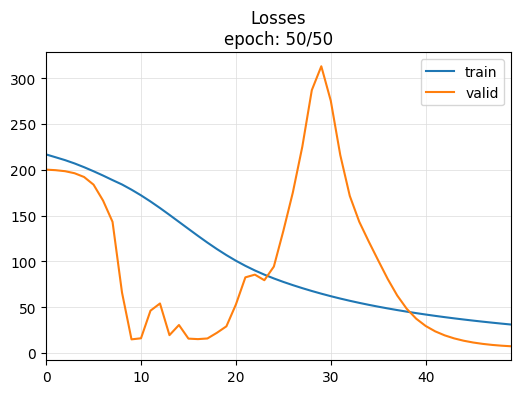

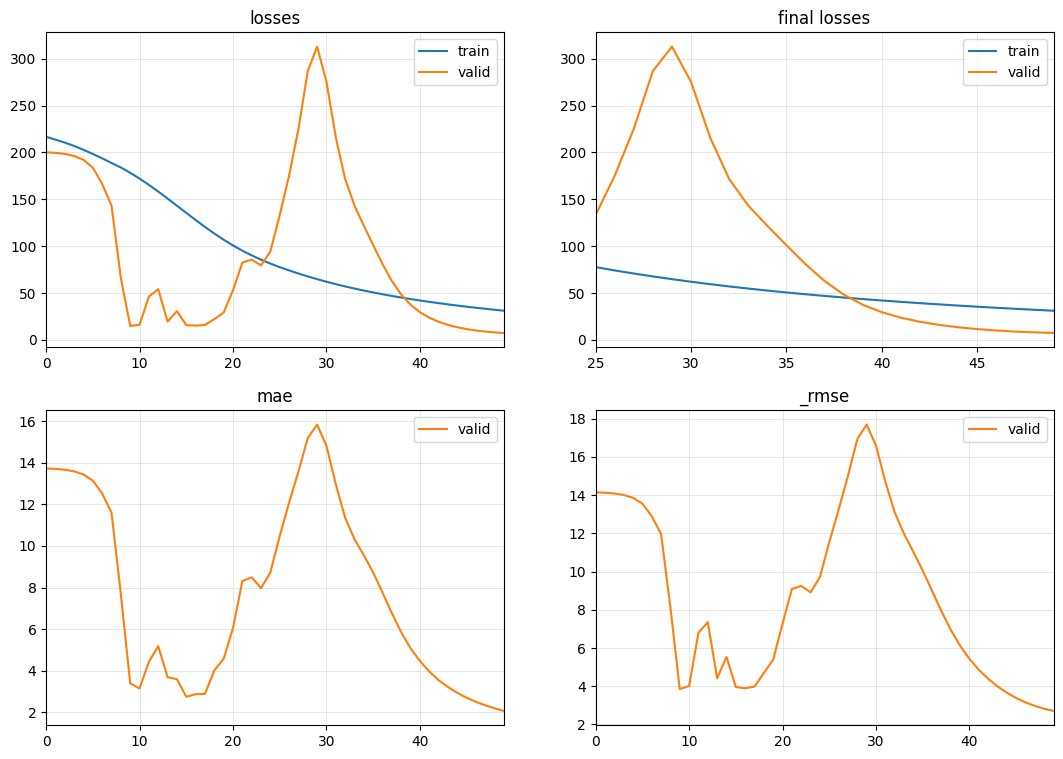

In [12]:
learn = ts_learner(dls, InceptionTime, metrics=[mae, rmse], cbs=ShowGraph())
learn.fit_one_cycle(50, 1e-2)

In [13]:
PATH = Path('./models/Regression.pkl')
PATH.parent.mkdir(parents=True, exist_ok=True)
learn.export(PATH)

In [14]:
del learn

## 推理 🧠

Inference ⎘

我们将使用模型进行推理，以便对验证集进行预测。我们将使用模型的 predict 方法，该方法将返回验证集的预测值。

We'll now upload the saved learner and create the predictions:

In [15]:
PATH = Path('./models/Regression.pkl')
learn = load_learner(PATH, cpu=False)

In [16]:
probas, _, preds = learn.get_X_preds(X[splits[1]])
skm.mean_squared_error(y[splits[1]], preds, squared=False)

2.702117213897469

正如您所看到的，这与训练结束时的有效 rmse 相匹配，因此模型预测正确。现在您可以传递任何数据并生成其他预测。

As you can see, this matches the valid rmse at the end of training, so the model is predicting correctly. Now you can pass any data and generate other predictions.

## 总结 ✅

Summary ✅

如您所见，使用 fastai 和 timeseriesAI 执行时间序列回归/预测任务非常简单。您唯一需要确定的是：

As you can see, to use fastai and timeseriesAI to perform a time series regression/ forecasting task is pretty easy. The only thing you need to make sure is that:

* 您的数据已正确准备（ys 作为浮点数）
* > Your data is correctly prepared (with ys as floats)
* 选择正确的指标（学习者将自动选择正确的损失，除非您想自己通过特定的损失）。
* > Select the right metrics (Learner will automatically select the right loss, unless you want to pass a specific one yourself).